# Affine transform

In this notebook, we check whether data coming from two different sites, but having the same class, could be transformed into each other using affine transforms.

In [1]:
from Data.Dataset import LatentFMRIDataset
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.covariance import empirical_covariance
from scipy.linalg import sqrtm
from scipy.stats import ortho_group
from SVM_Experiments import SVMAffine, SVMExperiment, SVMAffineWithoutClass
from sklearn.model_selection import train_test_split

In [2]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

### Dataset

In [3]:
data_shape = 1152

nyu_data_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_flat'
um1_data_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/UM_1_flat'
nyu_dataset = LatentFMRIDataset(data_dir=nyu_data_directory, data_shape=data_shape)
um1_dataset = LatentFMRIDataset(data_dir=um1_data_directory, data_shape=data_shape)

nyu_1 = nyu_dataset.get_items_from_class(cls=1)
nyu_2 = nyu_dataset.get_items_from_class(cls=2)
um1_1 = um1_dataset.get_items_from_class(cls=1)
um1_2 = um1_dataset.get_items_from_class(cls=2)

X_ny_1_train, X_ny_1_test, y_ny_1_train, y_ny_1_test = train_test_split(nyu_1, np.ones(nyu_1.shape[0]), test_size=0.2, random_state=0)
X_um_1_train, X_um_1_test, y_um_1_train, y_um_1_test = train_test_split(um1_1, np.ones(um1_1.shape[0]), test_size=0.2, random_state=0)

X_ny_2_train, X_ny_2_test, y_ny_2_train, y_ny_2_test = train_test_split(nyu_2, np.ones(nyu_2.shape[0]) + 1, test_size=0.2, random_state=0)
X_um_2_train, X_um_2_test, y_um_2_train, y_um_2_test = train_test_split(um1_2, np.ones(um1_2.shape[0]) + 1, test_size=0.2, random_state=0)

X_nyu_train = np.concatenate((X_ny_1_train, X_ny_2_train), axis=0)
y_nyu_train = np.concatenate((y_ny_1_train, y_ny_2_train), axis=0)

X_um_train = np.concatenate((X_um_1_train, X_um_2_train), axis=0)
y_um_train = np.concatenate((y_um_1_train, y_um_2_train), axis=0)

X_nyu_test = np.concatenate((X_ny_1_test, X_ny_2_test), axis=0)
y_ny_test = np.concatenate((y_ny_1_test, y_ny_2_test), axis=0)

X_um_test = np.concatenate((X_um_1_test, X_um_2_test), axis=0)
y_um_test = np.concatenate((y_um_1_test, y_um_2_test), axis=0)

### Empirical covariance
When the number of features is fixed and does not depend on the index of the sample, the empirical covariance matrix is a good estimator (https://math.mit.edu/~liewang/ECM.pdf)

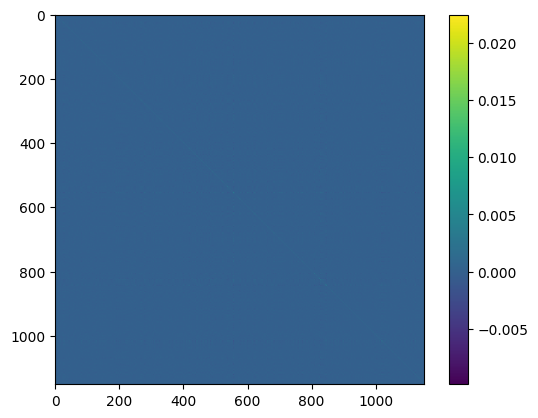

In [4]:
emprical_cov_mtx = empirical_covariance(nyu_1, assume_centered=False)
plt.imshow(emprical_cov_mtx)
plt.colorbar()
plt.show()

In [5]:
for site in [um1_1, um1_2, nyu_1, nyu_2]:
    print(f'Site is positive semidefinite: {is_pos_def(empirical_covariance(site, assume_centered=False))}')

Site is positive semidefinite: True
Site is positive semidefinite: True
Site is positive semidefinite: True
Site is positive semidefinite: True


### Compute the transformation
NYU -> UM_1 for the class labels {1, 2}

In [6]:
def compute_transform(source, target):
    c = empirical_covariance(source)
    c_aff = empirical_covariance(target)
    c_r = sqrtm(c)
    c_aff_r = sqrtm(c_aff)
    
    mean_aff = np.mean(target, axis=0)
    mean = np.mean(source, axis=0)
    
    Q = ortho_group.rvs(dim=c_r.shape[0]) # any orthogonal mtx is ok
    
    A_rec = c_aff_r @ Q @ np.linalg.inv(c_r)
    b_rec = mean_aff - A_rec.dot(mean)
    b_rec = np.expand_dims(b_rec, axis=-1)
    
    return A_rec, b_rec

In [7]:
A_1, b_1 = compute_transform(source=X_ny_1_train, target=X_um_1_train)
A_2, b_2 = compute_transform(source=X_ny_2_train, target=X_um_2_train)
A_all, b_all = compute_transform(source=X_nyu_train, target=X_um_train)

### Check the performance

Baseline without transformation

In [8]:
y_nyu_train.shape

(23660,)

[LibSVM].
*.*
optimization finished, #iter = 2302
obj = -963.658628, rho = -0.833007
nSV = 334, nBSV = 54
Total nSV = 334


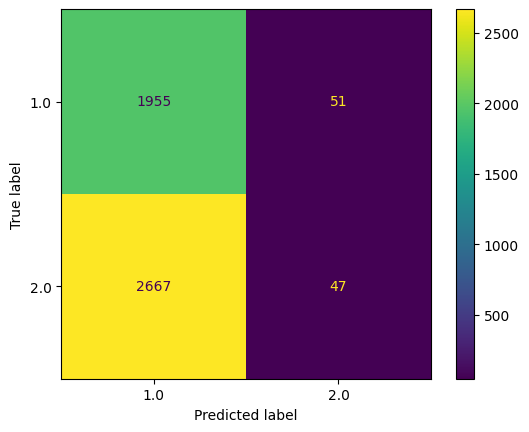

In [9]:
baseline_experiment = SVMExperiment(train_site_name='NYU',
                                    test_site_name='UM1',
                                    c_values=[10.0],
                                    data_shape=data_shape,
                                    X_train=X_nyu_train,
                                    y_train=y_nyu_train,
                                    X_test=X_um_test,
                                    y_test=y_um_test)
baseline_experiment.perform_experiment()

Using the transformation learned from the first class

[LibSVM]*
optimization finished, #iter = 89
obj = -5.654816, rho = 1.905269
nSV = 28, nBSV = 0
Total nSV = 28


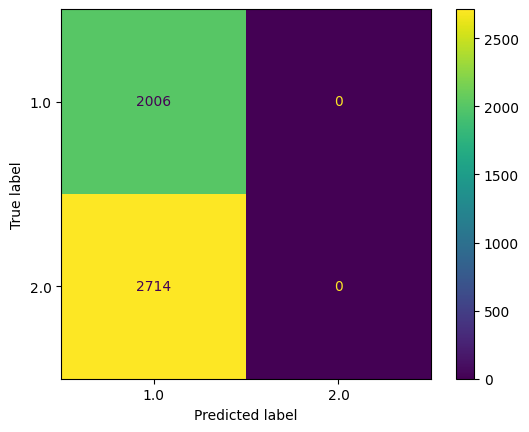

In [10]:
first_experiment = SVMAffine(
                        train_site_name='NYU',
                        test_site_name='UM1',
                        c_values=[10.0],
                        A1=A_1,
                        b1=b_1,
                        A2=A_1,
                        b2=b_1,
                        data_shape=data_shape,
                        X_train=X_nyu_train,
                        y_train=y_nyu_train,
                        X_test=X_um_test,
                        y_test=y_um_test)
first_experiment.perform_experiment()

Using the transform for the 2nd class

[LibSVM]*
optimization finished, #iter = 63
obj = -3.533942, rho = -1.449159
nSV = 30, nBSV = 0
Total nSV = 30


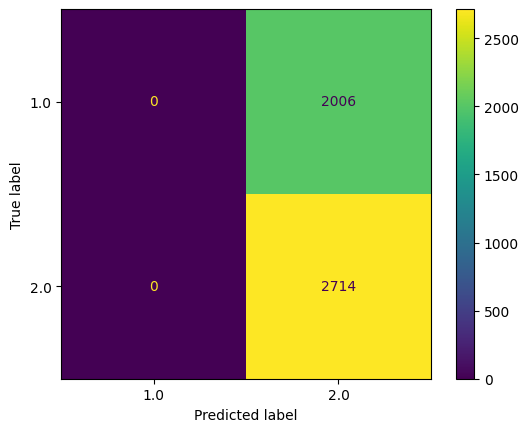

In [11]:
experiment = SVMAffine(train_site_name='NYU',
                       test_site_name='UM1',
                       c_values=[10.0],
                       A1=A_2,
                       b1=b_2,
                       A2=A_2,
                       b2=b_2,
                       data_shape=data_shape,
                       X_train=X_nyu_train,
                        y_train=y_nyu_train,
                        X_test=X_um_test,
                        y_test=y_um_test)
experiment.perform_experiment()

Using the transform learned from the whole train set

[LibSVM]...*...*
optimization finished, #iter = 6565
obj = -123.983090, rho = -0.004694
nSV = 1393, nBSV = 0
Total nSV = 1393


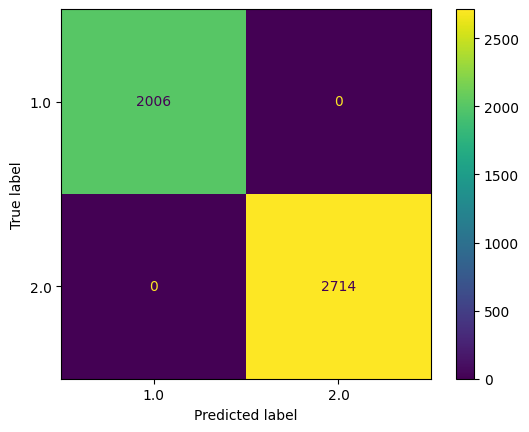

In [12]:
experiment = SVMAffine(train_site_name='NYU',
                       test_site_name='UM1',
                       c_values=[10.0],
                       A1=A_1,
                       b1=b_1,
                       A2=A_2,
                       b2=b_2,
                       data_shape=data_shape,
                       X_train=X_nyu_train,
                        y_train=y_nyu_train,
                        X_test=X_um_test,
                        y_test=y_um_test)
experiment.perform_experiment()

Transform learned on the whole set, without class differentiation

[LibSVM].........................................................................................*...................................................*
optimization finished, #iter = 140488
obj = -58745.966999, rho = -0.710763
nSV = 14152, nBSV = 4433
Total nSV = 14152


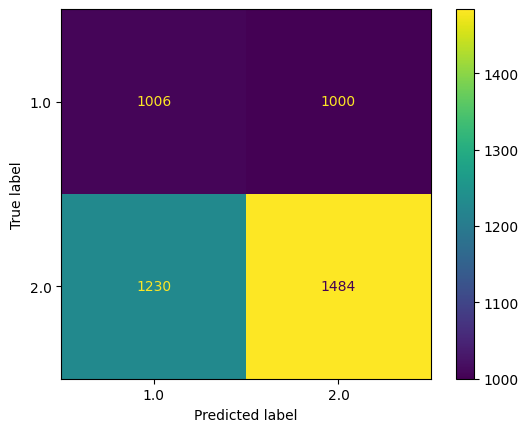

In [13]:
experiment = SVMAffineWithoutClass(train_site_name='NYU',
                       test_site_name='UM1',
                       c_values=[10.0],
                       A=A_all,
                       b=b_all,
                       data_shape=data_shape,
                       X_train=X_nyu_train,
                        y_train=y_nyu_train,
                        X_test=X_um_test,
                        y_test=y_um_test)
experiment.perform_experiment()